## Room Impulse Response Simulation for Various Array Architectures Using Monte-Carlo Simulation and Quaternions
This tool simulates the microphone positions of spherical, circular, uniform linear, or custom microphone arrays, as well as a source position in a given distance. The positions are randomly rotated and located in a room with a given minimum wall distance. Using these positions, room impulse responses can be simulated.

## Installation
Step 0: Install GNU parallel on your system

Step 1: Clone the project
```
git clone git@github.com:audiolabs/MonteCarloRIRSimulation.git
```
Step 2: Install the environment
```
pip install -r requirements.txt
```


## Here we learn how to use the provided library to 
## (to speed things up, go to the end and learn how to use the python files with parallel!)
1. Uniformly (stochastically and geometrically) sample a sphere 
2. Generate common and custom array architectures 
3. Rotate these architectures + sources 
4. Use all the before to generate room impulse responses for the array

In [41]:
from helper.ArrayStructures import SUA, ULA, CUA
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

def plot(points, title):
    plt.figure()
    ax = plt.axes(projection='3d')
    # Data for three-dimensional scattered points
    xdata = points[:,0]
    ydata = points[:,1]
    zdata = points[:,2]
    ax.scatter3D(xdata, ydata, zdata, cmap='Greens')
    ax.set_title(title)

### Sampling a Sphere Uniformly

Here we evaluate three methods to sample a sphere geometrically (1) or stochastically (2,3). 

In [40]:
from helper.UniformSphericalSampling import sample_sphere_uniformly_geometric, sample_sphere_uniformly_stochastic, sample_sphere_uniformly2_stochastic

In [5]:
def visualize_sampling(num_points):
    plt.figure()
    pointsg = sample_sphere_uniformly_geometric(num_points)
    pointsg[0].sort()
    pointsg[1].sort()
    plt.plot(pointsg[0],label='Azimuth')
    plt.title('Geometric Sampling: Azimuth and Elevation of different points')
    plt.plot(pointsg[1],label='Elevation')
    plt.legend()
    pointss = np.asarray([ sample_sphere_uniformly_stochastic() for a in range(num_points)])
    plt.figure()
    plt.plot(np.sort(pointss[:,0]),label='Azimuth')
    plt.title('Stochastic Sampling: Azimuth and Elevation of different points')
    plt.plot(np.sort(pointss[:,1]),label='Elevation')
    plt.legend()
    pointss2 = np.asarray([ sample_sphere_uniformly2_stochastic() for a in range(num_points)])
    plt.figure()
    plt.plot(np.sort(pointss2[:,0]),label='Azimuth')
    plt.title('Stochastic Sampling2: Azimuth and Elevation of different points')
    plt.plot(np.sort(pointss2[:,1]),label='Elevation')
    plt.legend()

For a high number of samples there is no difference between stochastic and geometric sampling as the distribution of azimuth and elevation angles looks equivalent


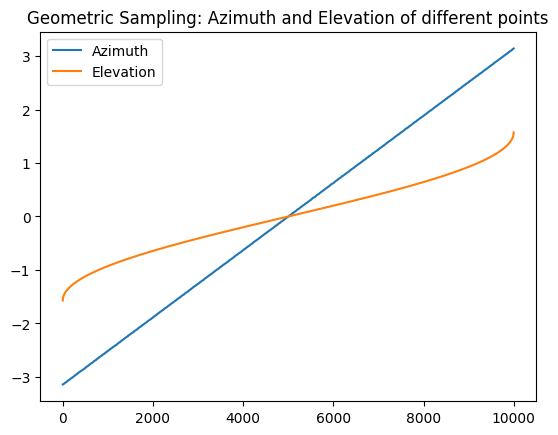

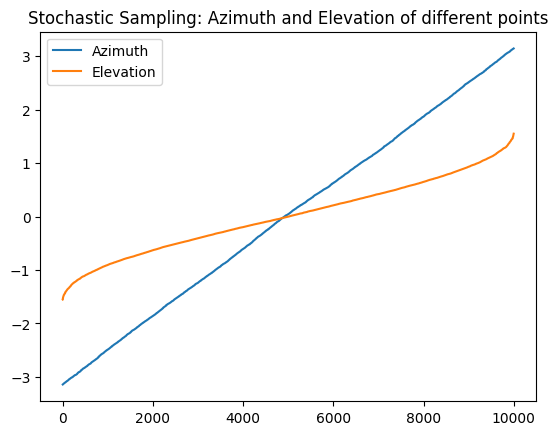

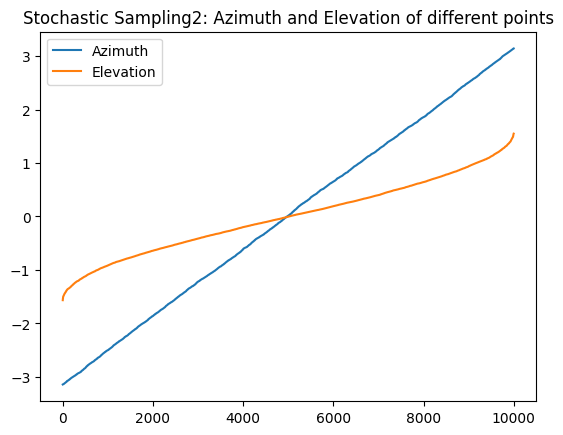

In [6]:
num_points = 10000
visualize_sampling(num_points)
print('For a high number of samples there is no difference between stochastic and geometric sampling as the distribution of azimuth and elevation angles looks equivalent')

For few samples, geometric sampling is preferred as it samples the azimuth and elevations pace appropriately also for a low number of points
For placing microphones equidistantly on a sphere, only geometric sampling can be used
For randomly determining source positions, also stochastic sampling can be used (for a large number of points)


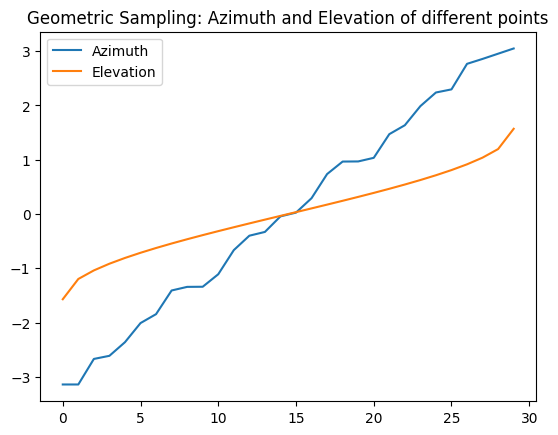

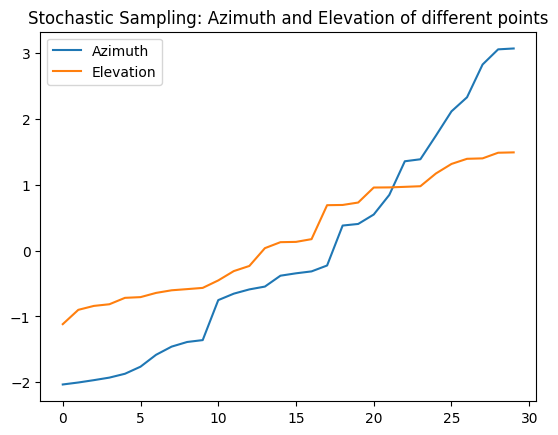

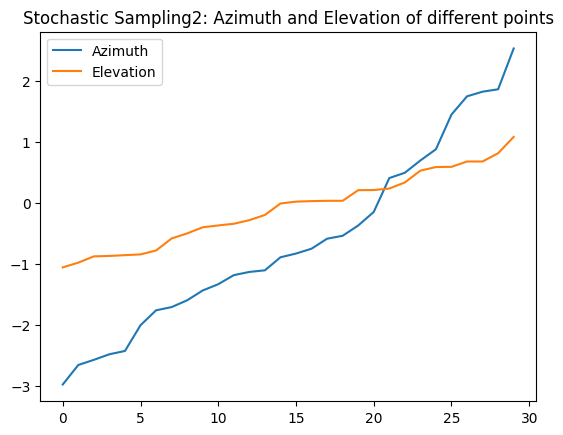

In [7]:
print('For few samples, geometric sampling is preferred as it samples the azimuth and elevations pace appropriately also for a low number of points')
print('For placing microphones equidistantly on a sphere, only geometric sampling can be used')
print('For randomly determining source positions, also stochastic sampling can be used (for a large number of points)')
num_points=30
visualize_sampling(num_points)

# Generate the Microphone Positions Uniform-Linear Arrays, Circular Linear Arrays, and Spherical Linear Arrays

Using geometric sampling, we can place points approximately equidistantly on a sphere. We can translate the azimuth and elevation angles to vectors pointing from the sphere center to the respective positions:


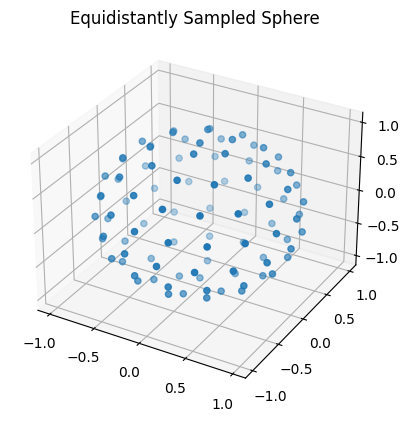

In [8]:
from RIR_write_quaternion import generate_source_vec
num_points = 100
# 1 Get azimuth and elevation geometrically determined 
pointsg = sample_sphere_uniformly_geometric(num_points)
# 2 Translate azimuth and elevation to pointing vectors
radius = 1
vecs = []
for a in range(len(pointsg[0])):
    vecs.append(generate_source_vec(radius, pointsg[0][a], pointsg[1][a]))
# 3 Visualize points on the sphere
plot(np.asarray(vecs),'Equidistantly Sampled Sphere')

The procedure is included in from helper.ArrayStructures import SUA, ULA, CUA to generate the respective array structures: spherical uniform array (SUA), uniform-linear array (ULA), circular uniform array (CUA)

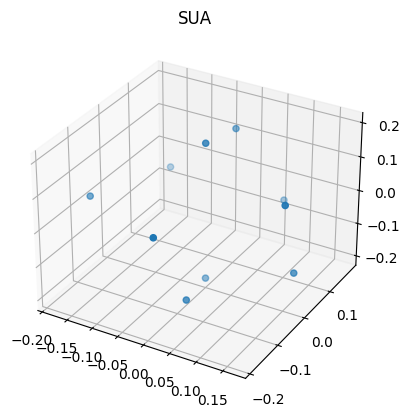

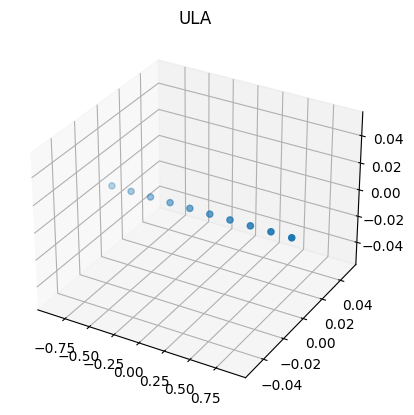

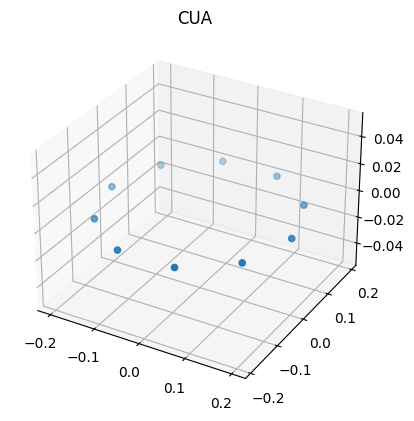

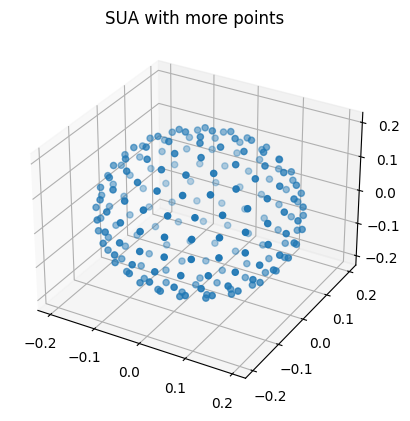

In [9]:
# Create 'num_microphones' microphone positions for a spherical uniform array with radius/length 'radius'. 
# We use a geometric sampling such that the points have approximate equal distance on a sphere (exact equal distance is mathematically not possible for an arbitrary number of points, if it is possible, the microphone-distances are exactly the same)
num_microphones = 10
# for a uniform-linear array (ULA) radius specifies the inter-microphone distance; In spherical uniform array (SUA) and  circular uniform array (CUA), radius specifies the distance of each microphone to the array center
radius = 0.2
for array in [SUA, ULA, CUA]:
    points = array(radius,num_microphones)
    plot(points,array.__name__)

# With more points 
num_microphones = 200 
for array in [SUA]:
    points = array(radius,num_microphones)
    plot(points,array.__name__+ ' with more points')

# Using Quaternions to translate azimuth and elevation to pointing vectors

In [10]:
from helper.Quaternions import QuatProc

To change the radius, just multiply all vectors with the same number


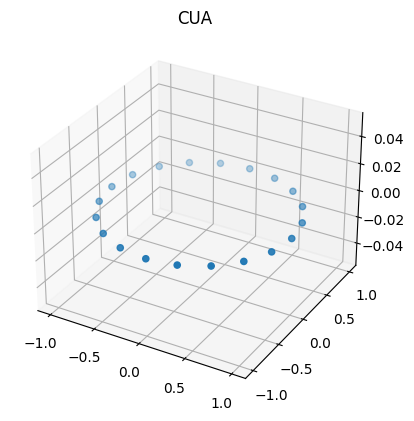

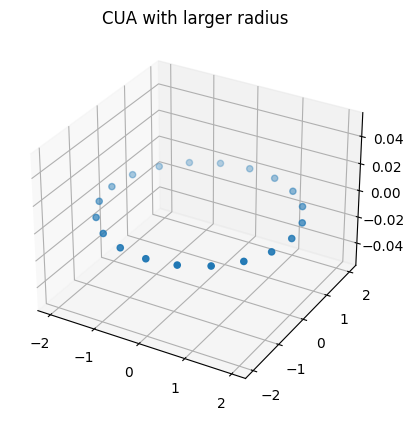

In [11]:
# Make a circular uniform array from scratch
# 1 Define a start coordinate
start = np.array([0,1,0])
# 2 Define a vector to form the circular array around (orthogonal to start vector)
ref_vec = np.array([0,0,1])
# 3 Define the number of microphones 
num_points = 20
# 4 Initialize the Quaternion Processer ... it is basically a matrix storage that knows how to do the matrix mutliplication accordingly
# Initialize Quaternion Processer 
proc = QuatProc()
# 5 Define delta rotation angle to get a full circle of the CUA
rot_angle = 2*np.pi/num_points
points = []
for a in np.arange(0,num_points):
    # now rotate each vector according to the respective angle difference rot_angle
    start = proc.rotate(rot_angle,ref_vec, start)
    points.append(start)
points = np.asarray(points)
plot(points, 'CUA')
print('To change the radius, just multiply all vectors with the same number')
radius = 2
plot(points*radius,'CUA with larger radius')

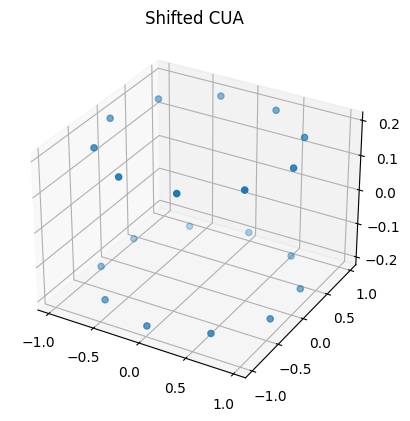

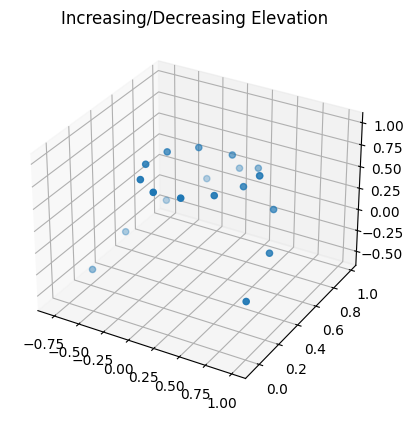

In [12]:
# You can also make for customized shapes by setting azimuth and elevation respectively, here are some examples: 

# Lets simplify things again by using 'generate_source_vec'
from RIR_write_quaternion import generate_source_vec
# To make things more difficult, we shift every microphone position by +- pi/16 in elevation using 'generate_source_vec'
azimuths = 2*np.pi/num_points*np.arange(num_points)
shifted_points = []
for a in range(num_points):
    elevation = (-1)**a*np.pi/16
    vec = generate_source_vec(1,azimuths[a],elevation)
    shifted_points.append(vec)
shifted_points = np.asarray(shifted_points)
plot(shifted_points, 'Shifted CUA')

# Or increase the elevation ... till it surpasses+-pi/2 and decreases again
from RIR_write_quaternion import generate_source_vec
azimuths = 2*np.pi/num_points*np.arange(num_points)
shifted_points = []
for a in range(num_points):
    elevation = a*np.pi/16
    vec = generate_source_vec(1,azimuths[a],elevation)
    shifted_points.append(vec)
shifted_points = np.asarray(shifted_points)
plot(shifted_points,'Increasing/Decreasing Elevation')
# More custom shapes are up to you, just specify azimuth and elevation pairs in generate_source_vec

# Randomly rotating the microphone positions and the respective source positions

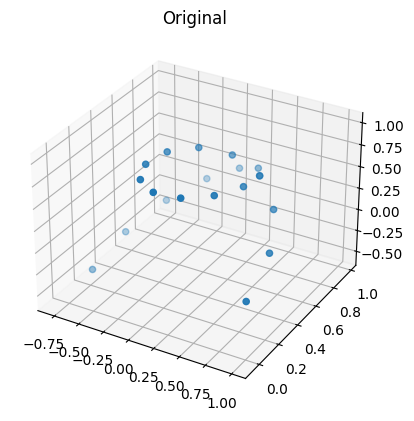

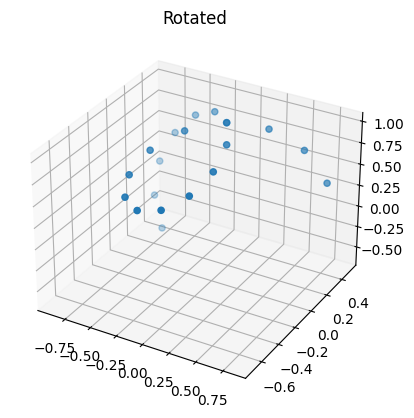

In [13]:
# use increasing/decreasing elevation from above: 
azimuths = 2*np.pi/num_points*np.arange(num_points)
shifted_points = []
for a in range(num_points):
    elevation = a*np.pi/16
    vec = generate_source_vec(1,azimuths[a],elevation)
    shifted_points.append(vec)
shifted_points = np.asarray(shifted_points)
##### Just use different points if you want to see another microphone array

proc = QuatProc()
# get random rotation vector (reference vector to rotate around) 
rv = proc.random_rotation()
# get a random angle (uniformly sampled) between 0 and 2 pi to rotate around rv
rangle = np.random.rand()*2*np.pi
res = [ ]
for a in range(shifted_points.shape[0]):
    res.append(proc.rotate(rangle, rv, shifted_points[a,...]))
plot(shifted_points,'Original')
plot(np.asarray(res),'Rotated')

# Adding a source to the microphone Array with a certain distance is quite easy ... just use the same procedure 

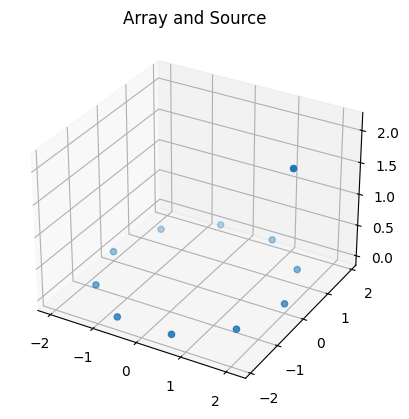

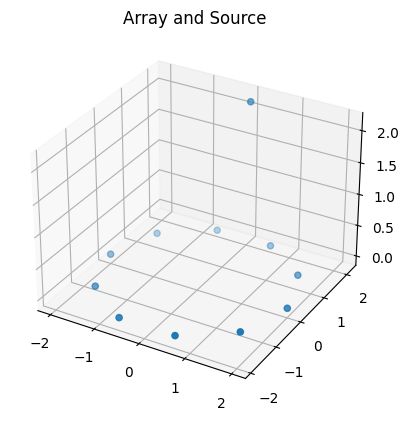

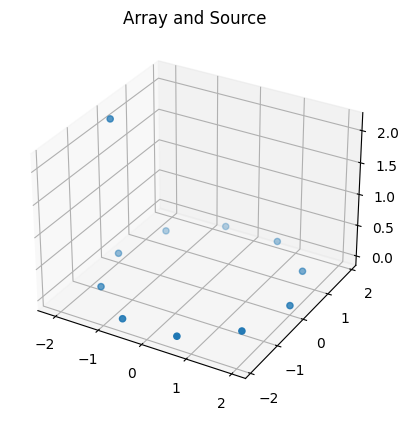

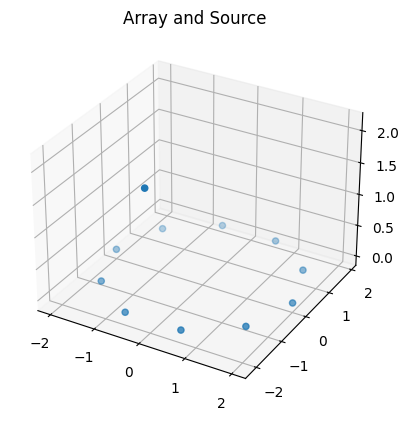

In [14]:
# 1 Get the microphone points for a CUA 
num_mics = 10 
radius = 2
mic = CUA(radius,num_mics)
# 2 Get a source lets say at elevation = 45 and azimuth = 0 in 2 m distance
source_dist = 3
azimuth = np.pi/2
elevation =  45/360.*2*np.pi
# 3 Let the source move around 
for a in range(4):
    source = generate_source_vec(source_dist, azimuth*a,elevation)
    plot(np.concatenate([mic,source[None,...]],axis=0),'Array and Source')


As both, array and source are centered around zero, the whole construct can be rotated using random vectors (as above): 

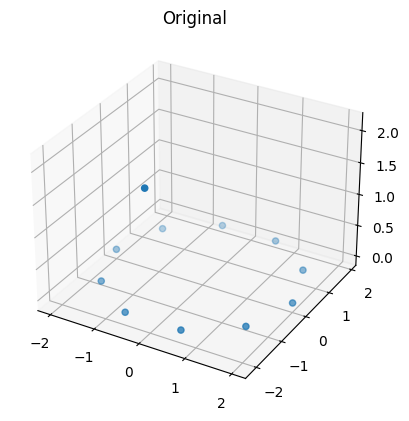

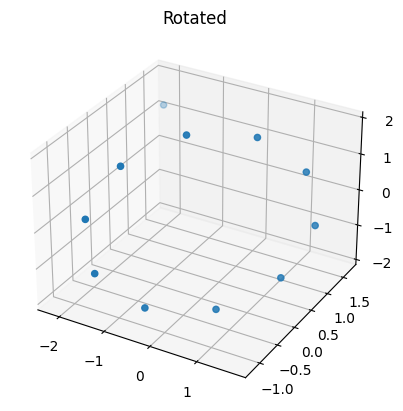

In [15]:
vecs = np.concatenate([mic,source[None,...]])
proc = QuatProc()
# get random rotation vector (reference vector to rotate around) 
rv = proc.random_rotation()
# get a random angle (uniformly sampled) between 0 and 2 pi to rotate around rv
rangle = np.random.rand()*2*np.pi
res = [ ]
for a in range(vecs.shape[0]):
    res.append(proc.rotate(rangle, rv, vecs[a,...]))
plot(vecs, 'Original')
plot(np.asarray(res), 'Rotated')


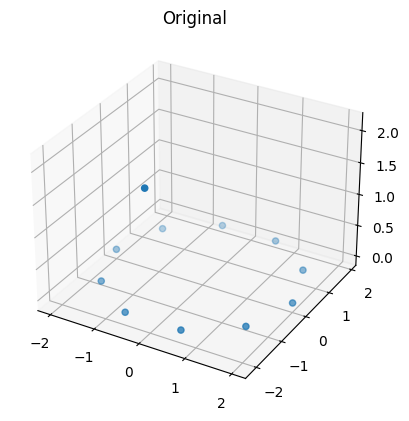

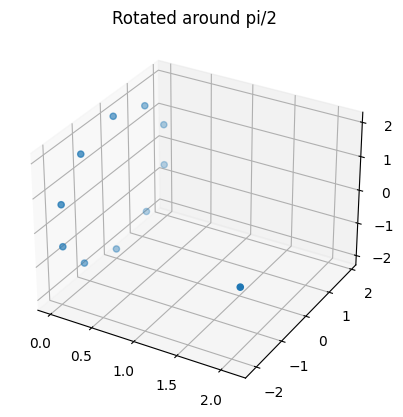

In [16]:
# If you want to use a user-defined rotation, just do so, e.g., 
rot_vec = np.array([0,1,0])
angle = np.pi/2
res = [ ]
for a in range(vecs.shape[0]):
    res.append(proc.rotate(angle, rot_vec, vecs[a,...]))
plot(vecs, 'Original')
plot(np.asarray(res), 'Rotated around pi/2')
# You see that the array center is always at [0,0,0], so the rotation has to be performed before putting the array in the room!

# Placing the Array and the Source in a Room of certain shape with a specified minimum distance to walls

In [17]:
from RIR_write_quaternion import sample_room
?sample_room

In [18]:
# Get a point in the room with a minimal distance to walls wdist [m]
room = np.asarray([6,7,4]) # width, length, height
wdist = 1 
room_point = sample_room(room,wdist)

In [19]:
# Add the room point to the (rotated) microphone positions and the source position such that they are placed in the room
room_poses = np.concatenate([mic,source[None,...]],axis=0) + room_point
# these positions can now be used in the rir-generator ... if they are valid-> next: test for validity

In [20]:
# Check whether all positions are still within the safety margin (wdist) of the room 
from RIR_write_quaternion import verify_positions
# save all array/source coordinates in a room for s samples 
s = 1000
room_points = []
mics = []
sources = []
for a in range(s):
    #1 Make the array positions 
    num_mics = 10 
    radius = 0.2
    mic = CUA(radius,num_mics)

    #2 make the source coordinate
    source_dist = 0.5
    azimuth = 0
    elevation =  45/360.*2*np.pi
    source = generate_source_vec(source_dist, azimuth,elevation)

    #3 define the room 
    room = np.array([7,5,3])
    room_point = sample_room(room, wdist)

    #4 check whether every coordinate is in the room and does not cut wdist 
    while not verify_positions(room, mic + room_point, source + room_point, wdist = wdist):
        room_point = sample_room(room, wdist)
    room_points.append(room_point)
    mics.append(mic + room_point)
    sources.append(source + room_point)
room_points = np.asarray(room_points)
sources = np.asarray(sources)
mics = np.asarray(mics)


# If the function returns false, you have to use another point or make the array/source-distance smaller
# Note, by randomly rotating the array + source before adding the room, also rooms that are not too high can be used
# Note, if your array+source does not fit in the room with safety margin (both sides!) the function will be caught in an infinite loop
# 5 Use the coordinates to generate room impulse responses https://pypi.org/project/rir-generator/

Now lets look how the microphones, sources and room points are distributed:

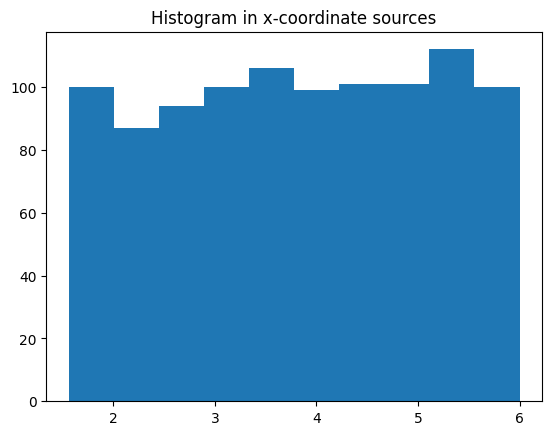

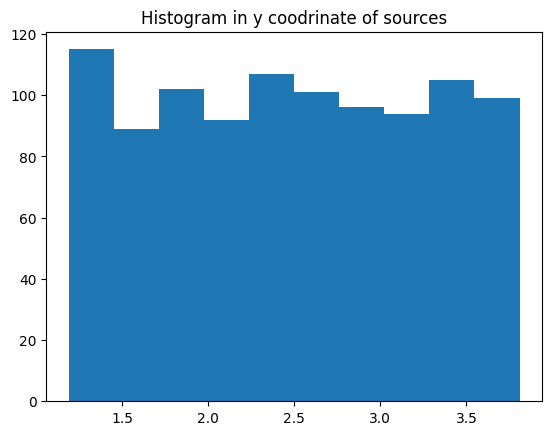

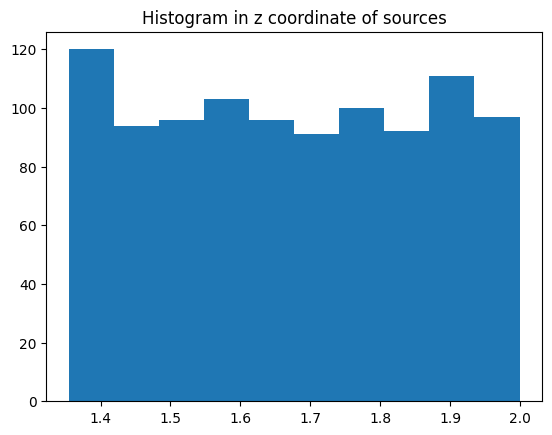

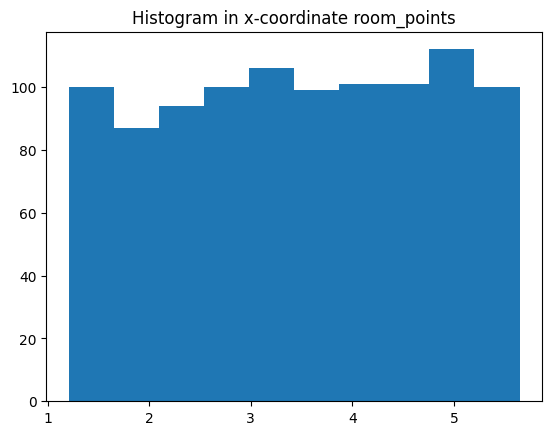

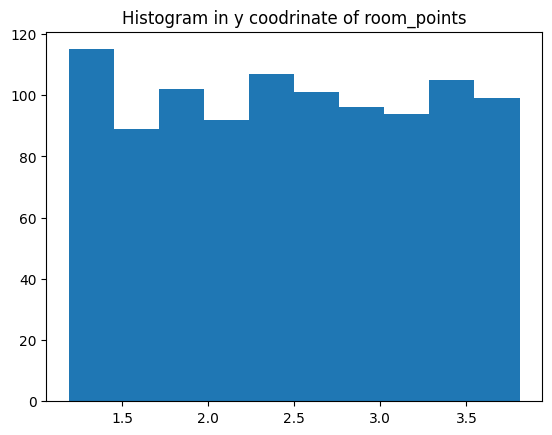

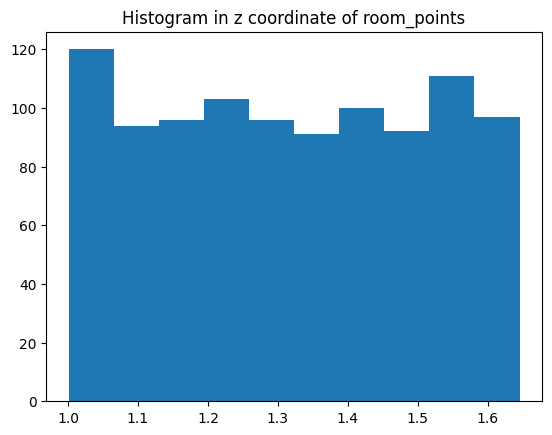

<Figure size 640x480 with 0 Axes>

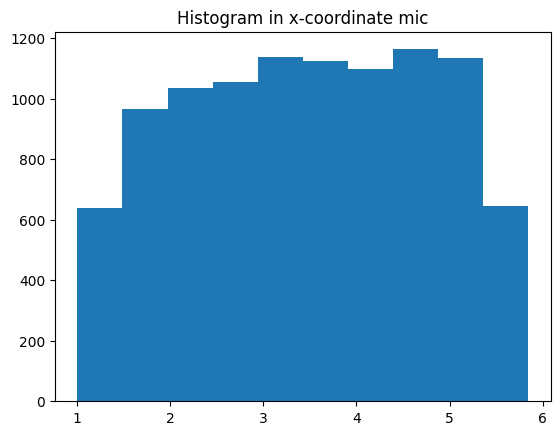

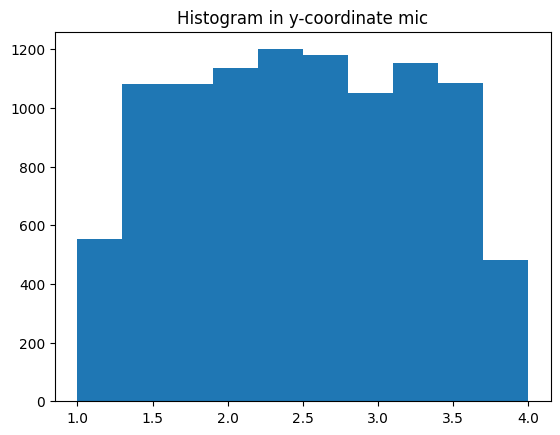

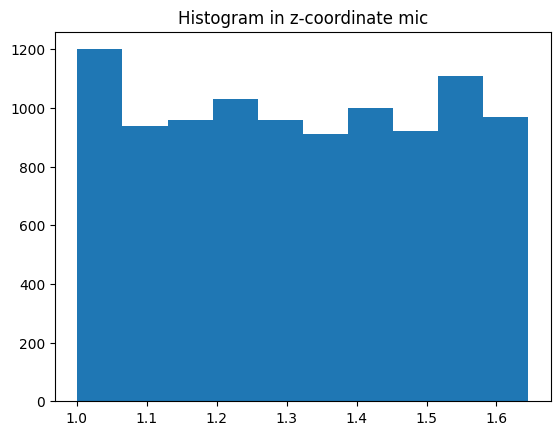

In [38]:
for v in [('sources', np.asarray(sources)), ('room_points', np.asarray(room_points))]:
    plt.hist(x=v[1][:,0])
    plt.title(label='Histogram in x-coordinate {}'.format(v[0]))
    plt.figure()
    plt.hist(x=v[1][:,1])
    plt.title('Histogram in y coodrinate of {}'.format(v[0]))
    plt.figure()
    plt.hist(x=v[1][:,2])
    plt.title('Histogram in z coordinate of {}'.format(v[0]))
    plt.show()
    plt.figure()
    
    
micros = mics.reshape([mics.shape[0]*mics.shape[1],3])
for c in [('x',0),('y',1), ('z',2)]:
    plt.figure()
    plt.hist(micros[:,c[1]])
    plt.title(label='Histogram in {}-coordinate {}'.format(c[0],'mic'))
    plt.show()
   

# Generate Room Impulse Responses
From the previous section, we have the arrays mics, sources, and the room geometry. We sampled 1000 times the SUA in a room with 10 microphones, such that mic has a shape of (1000, 10, 3) corresponding to (samples, microphones, coordinates). Using these sampled points, we can generater room impulse respones via: 

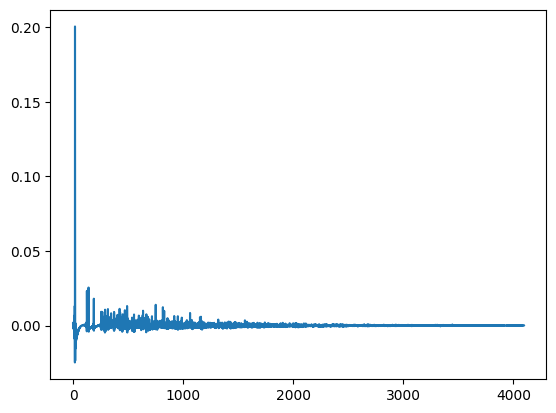

In [34]:
import rir_generator as rgen
h = rgen.generate(
    c=340,                  # Sound velocity (m/s)
    fs=16000,                  # Sample frequency (samples/s)
    r=mics[0,...],               # Microphones
    s=sources[0,...],          # Source position [x y z] (m)
    L=room,            # Room dimensions [x y z] (m)
    reverberation_time=0.4, # Reverberation time (s)
    nsample=4096,           # Number of output samples
)
# result are 10 room impulse responses of h.shape that simulate the path of the source to each microphone.
plt.plot(h[:,0])
plt.show()

### To speed things up, the process of RIR generation is parallelized with GNU parallel. You can use it via

In [26]:
!python ./RIR_parameter.py | parallel --colsep ' ' python ./RIR_write_quaternion.py

^C


You can set the specific parameters in the ```config/config.py``` (like room dimensions etc.) The files are saved in the folder specified in the config file. They are saved in a .pickle format. 

### Examplary loading of a  file generated from the default config

In [24]:
import pickle
rir_file = pickle.load(open('output/Room943Rev0.38ArraySUASMD0.08ind0sadist1.2.pickle', 'rb'))
print(rir_file.keys())

dict_keys(['RIR', 'Dist', 'Vecs', 'DirectRIR'])


RIR specifies the room impulse response, dist specifies the source array-center distance, Vecs are vectors pointing from array to source and DirectRIR contains only the direct comoponent of the room impulse response

In [27]:
rir_file['RIR'].shape

(37, 6080, 4)

We have 37 room impulse responses of length 6080 and four microphones, as secified in the config. The DOA space was equally divided into 37 parts (source positions w.r.t. the array). For a ULA this is a resolution of 5 degrees: 180/(37-1). The length of the room impulse responses depends on the reverberation time. 

In [25]:
len(rir_file['Vecs'])
# the vetors form a half-circle for a ULA, a half-sphere for a CUA and a sphere for a SUA

37

Now you can use the generated room impulse responses. 